In [1]:
%matplotlib notebook
import gmaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as sci

from config import gkey,api_key
from census import Census
from census_vars import censuskey,censusval

def coordinates(loc):
    params = {"address": loc, "key":gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params = params)
    place_geo = response.json()
    lat = place_geo['results'][0]["geometry"]['location']['lat']
    lng = place_geo['results'][0]["geometry"]['location']['lng']
    return lat, lng

c = Census(api_key, year=2018)
gmaps.configure(api_key = gkey)

In [2]:
df = pd.read_excel("Tables/Table_13_Hate_Crime_Incidents_per_Bias_Motivation_and_Quarter_by_State_and_Agency_2018.xlsm")
df.dropna(inplace=True)
ls = []
for x in df["Agency name"]:
    if '3' in x:
        #print(x)
        ls.append(x[:-1])
    else:
        ls.append(x)
df["Agency name"] = ls

In [3]:
# results saved to file locations.csv, not worth re-running outside of error
#df["Lat"] = ""
#df["Lng"] = ""
#for i,r in df.iterrows():
#    st = r[2] + ',' + r[0]
#    lat,lng = coordinates(st)
#    df.loc[i,["Lat"]] = lat
#    df.loc[i,["Lng"]] = lng
#locations_df = df.loc[:,['State', 'Agency name', 'Lat', 'Lng']]

#locations_df.to_csv("locations.csv")

In [3]:
location_df = pd.read_csv("locations.csv")
location_df["Loc"] = location_df["State"] + "," + location_df["Agency name"]

df["Loc"] = df["State"] + "," + df["Agency name"]
dfa = pd.merge(df,location_df,on=["Loc","Loc"])
dfa = dfa.loc[:,['Loc', 'Lat', 'Lng','Population', 'Race/Ethnicity/Ancestry',
       'Religion', 'Sexual Orientation', 'Disability', 'Gender',
       'Gender identity']]
dfa["Total"] = dfa["Race/Ethnicity/Ancestry"] + dfa["Religion"] + dfa["Gender"] + dfa["Gender identity"] + dfa["Disability"]
loc = dfa.loc[:,["Lat","Lng"]]
dfa

,Loc,Lat,Lng,Population,Race/Ethnicity/Ancestry,Religion,Sexual Orientation,Disability,Gender,Gender identity,Total
0,"Alaska,Anchorage",61.218056,-149.900278,291992.0,1,0,0,0,0,0,1
1,"Alaska,Fairbanks",64.837778,-147.716389,31635.0,2,0,0,1,0,0,3
2,"Alaska,Juneau",58.301944,-134.419722,31922.0,0,2,0,0,0,0,2
3,"Alaska,Kotzebue",66.898333,-162.596667,3273.0,1,0,0,0,0,0,1
4,"Arizona,Coolidge",32.977839,-111.517624,12815.0,2,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
1458,"Wisconsin,Seymour",44.514988,-88.330380,3460.0,1,0,0,0,0,0,1
1459,"Wisconsin,Sheboygan",43.750828,-87.714530,48195.0,0,0,0,1,0,0,1
1460,"Wisconsin,Stevens Point",44.523579,-89.574563,26233.0,2,0,0,0,0,0,2
1461,"Wisconsin,Waterloo",43.183884,-88.988442,3337.0,0,1,0,0,0,0,1


In [4]:
grouped_df = df.groupby("State").sum()
grouped_df.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity']]
grouped_df["Total"] = grouped_df["Race/Ethnicity/Ancestry"] + grouped_df["Religion"] + grouped_df["Gender"] + grouped_df["Gender identity"] + grouped_df["Disability"] + grouped_df["Sexual Orientation"]


<IPython.core.display.Javascript object>


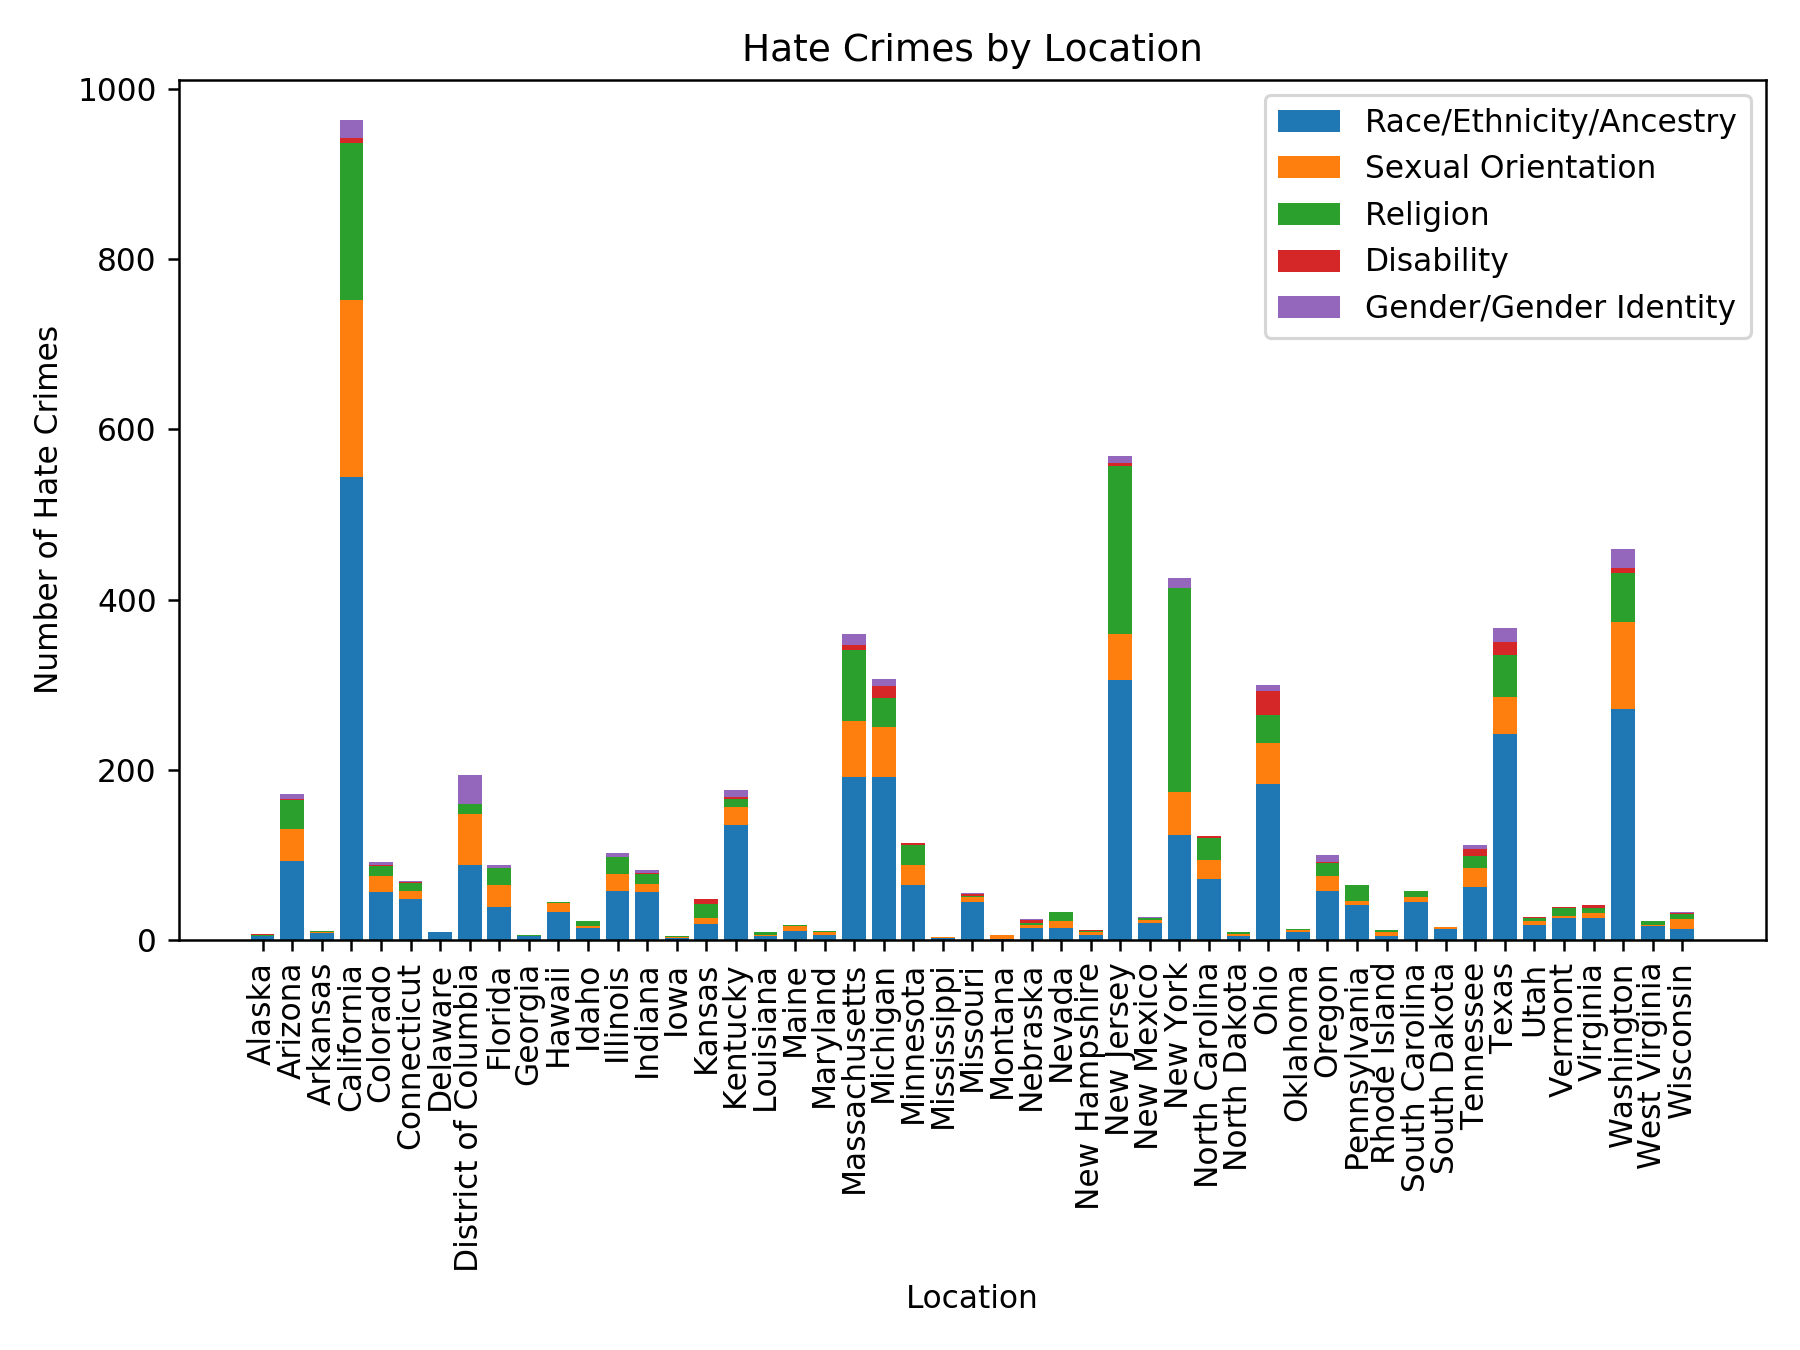

In [5]:
plt.figure(figsize=(8,6))

race = plt.bar(range(grouped_df.shape[0]),grouped_df["Race/Ethnicity/Ancestry"])
sex  = plt.bar(range(grouped_df.shape[0]),grouped_df["Sexual Orientation"],bottom=grouped_df["Race/Ethnicity/Ancestry"])
rel  = plt.bar(range(grouped_df.shape[0]),grouped_df["Religion"], bottom = grouped_df["Race/Ethnicity/Ancestry"]+ grouped_df["Sexual Orientation"])
dis  = plt.bar(range(grouped_df.shape[0]),grouped_df["Disability"], bottom = grouped_df["Race/Ethnicity/Ancestry"] + grouped_df["Sexual Orientation"]+ grouped_df["Religion"])
gen  = plt.bar(range(grouped_df.shape[0]),grouped_df["Gender"] + grouped_df["Gender identity"], bottom = grouped_df["Race/Ethnicity/Ancestry"]+ grouped_df["Sexual Orientation"] + grouped_df["Religion"] + grouped_df["Disability"])

ind = list(grouped_df.index)
plt.xticks(range(grouped_df.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crimes by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Number of Hate Crimes")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

#plt.savefig("HateCrimes.png")

In [6]:
grouped_percent = grouped_df.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
grouped_percent["Race/Ethnicity/Ancestry"] = grouped_df["Race/Ethnicity/Ancestry"]/grouped_df["Total"]
grouped_percent["Disability"] = grouped_df["Disability"]/grouped_df["Total"]
grouped_percent["Religion"] = grouped_df["Religion"]/grouped_df["Total"]
grouped_percent["Gender identity"] = grouped_df["Gender identity"]/grouped_df["Total"]
grouped_percent["Gender"] = grouped_df["Gender"]/grouped_df["Total"]
grouped_percent["Sexual Orientation"] = grouped_df["Sexual Orientation"]/grouped_df["Total"]

<IPython.core.display.Javascript object>


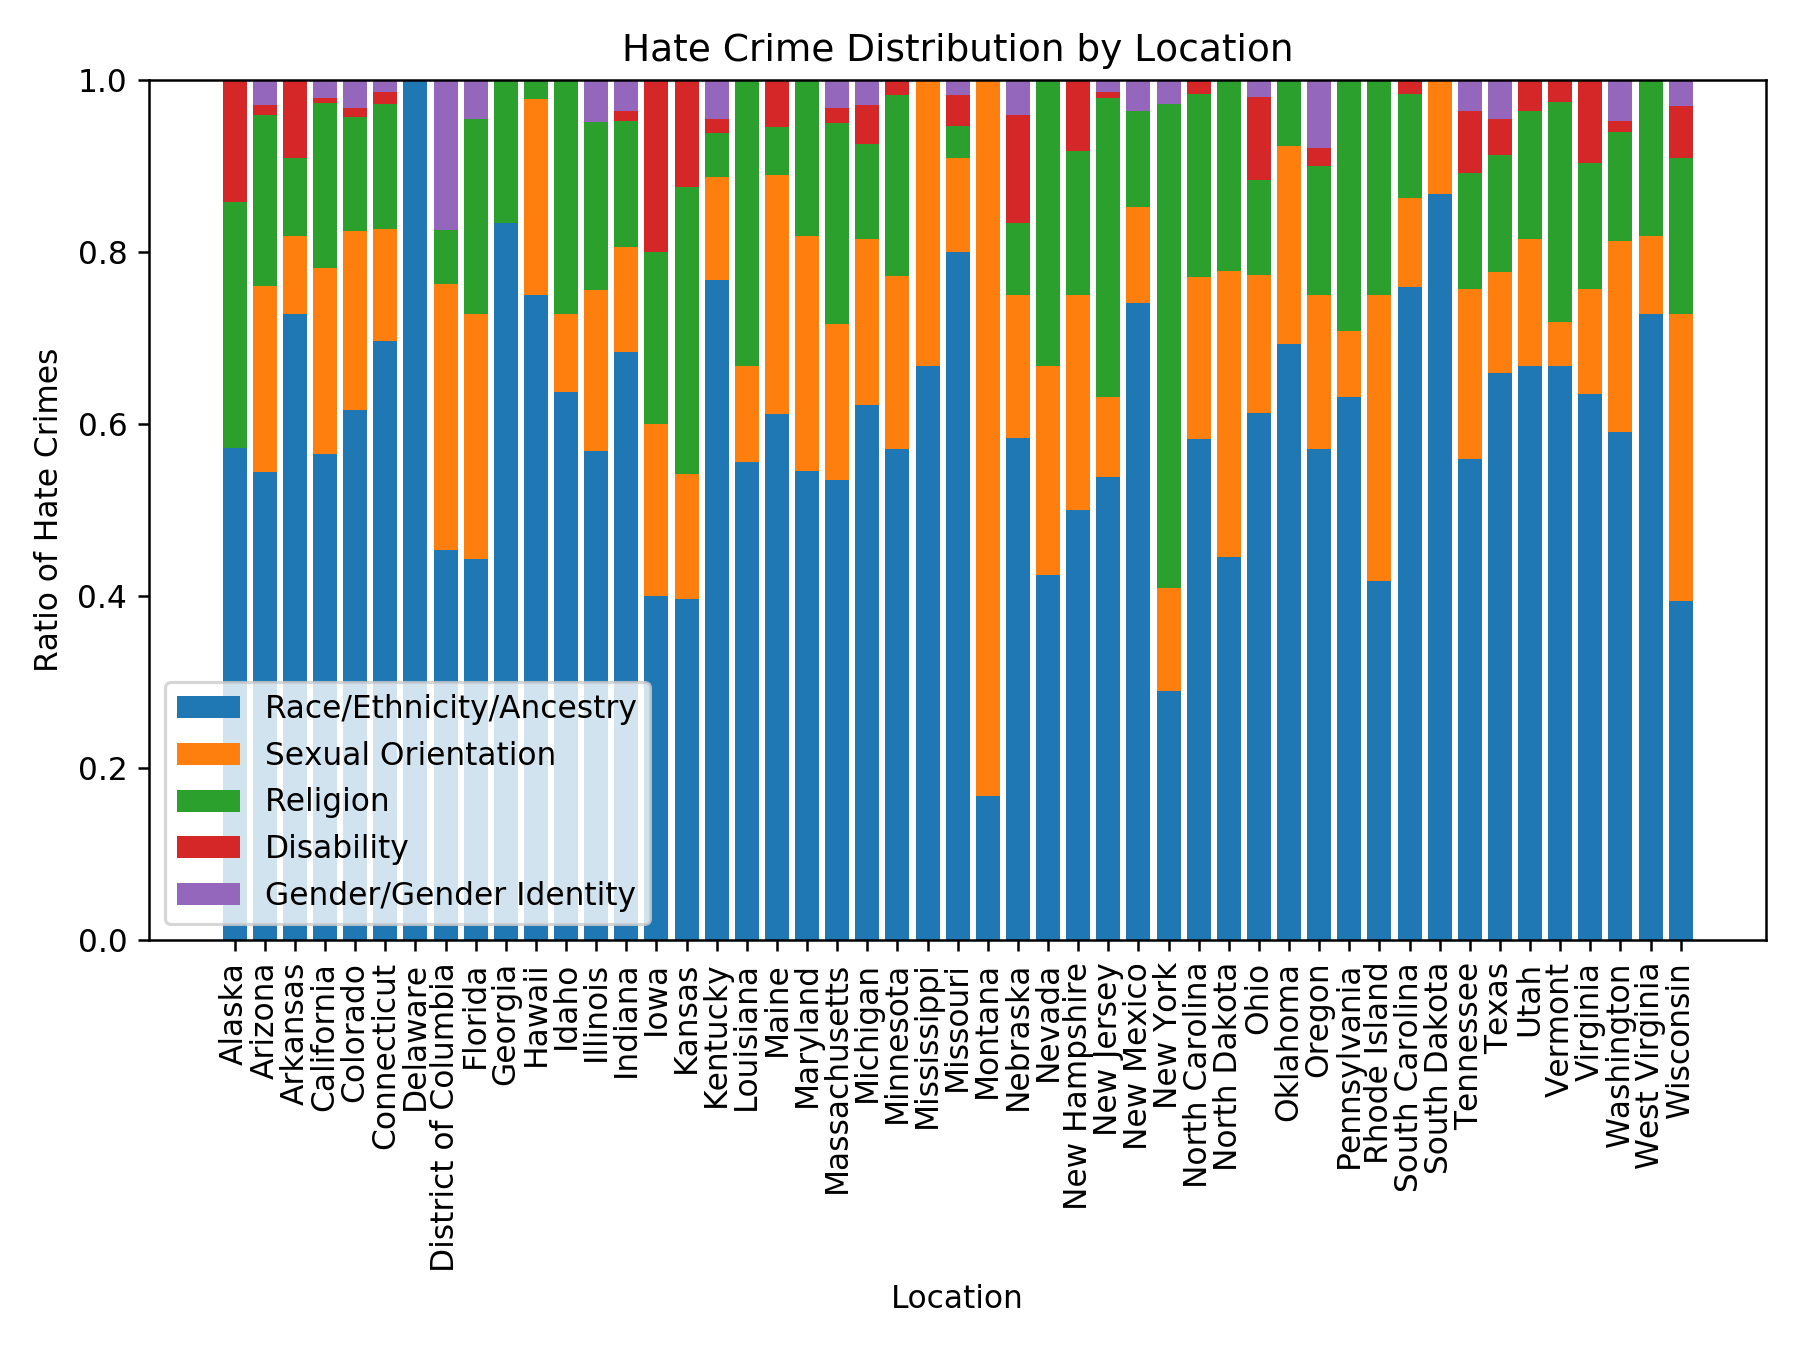

In [7]:
plt.figure(figsize=(8,6))
race = plt.bar(range(grouped_df.shape[0]),grouped_percent["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(grouped_df.shape[0]),grouped_percent["Sexual Orientation"],bottom=grouped_percent["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(grouped_df.shape[0]),grouped_percent["Religion"], bottom = grouped_percent["Race/Ethnicity/Ancestry"]+ grouped_percent["Sexual Orientation"])
dis = plt.bar(range(grouped_df.shape[0]),grouped_percent["Disability"], bottom = grouped_percent["Race/Ethnicity/Ancestry"] + grouped_percent["Sexual Orientation"]+ grouped_percent["Religion"])
gen = plt.bar(range(grouped_df.shape[0]),grouped_percent["Gender"] + grouped_percent["Gender identity"], bottom = grouped_percent["Race/Ethnicity/Ancestry"]+ grouped_percent["Sexual Orientation"] + grouped_percent["Religion"] + grouped_percent["Disability"])

ind = list(grouped_df.index)
plt.xticks(range(grouped_df.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crime Distribution by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Ratio of Hate Crimes")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

#plt.savefig("HateCrimesRelative.png")

In [8]:
grouped_per_capita = grouped_df.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
grouped_per_capita["Race/Ethnicity/Ancestry"] = grouped_df["Race/Ethnicity/Ancestry"]/grouped_df["Population"]
grouped_per_capita["Disability"] = grouped_df["Disability"]/grouped_df["Population"]
grouped_per_capita["Religion"] = grouped_df["Religion"]/grouped_df["Population"]
grouped_per_capita["Gender identity"] = grouped_df["Gender identity"]/grouped_df["Population"]
grouped_per_capita["Gender"] = grouped_df["Gender"]/grouped_df["Population"]
grouped_per_capita["Sexual Orientation"] = grouped_df["Sexual Orientation"]/grouped_df["Population"]
grouped_per_capita = grouped_per_capita.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation','Disability', 'Gender', 'Gender identity']] * 1000000


<IPython.core.display.Javascript object>


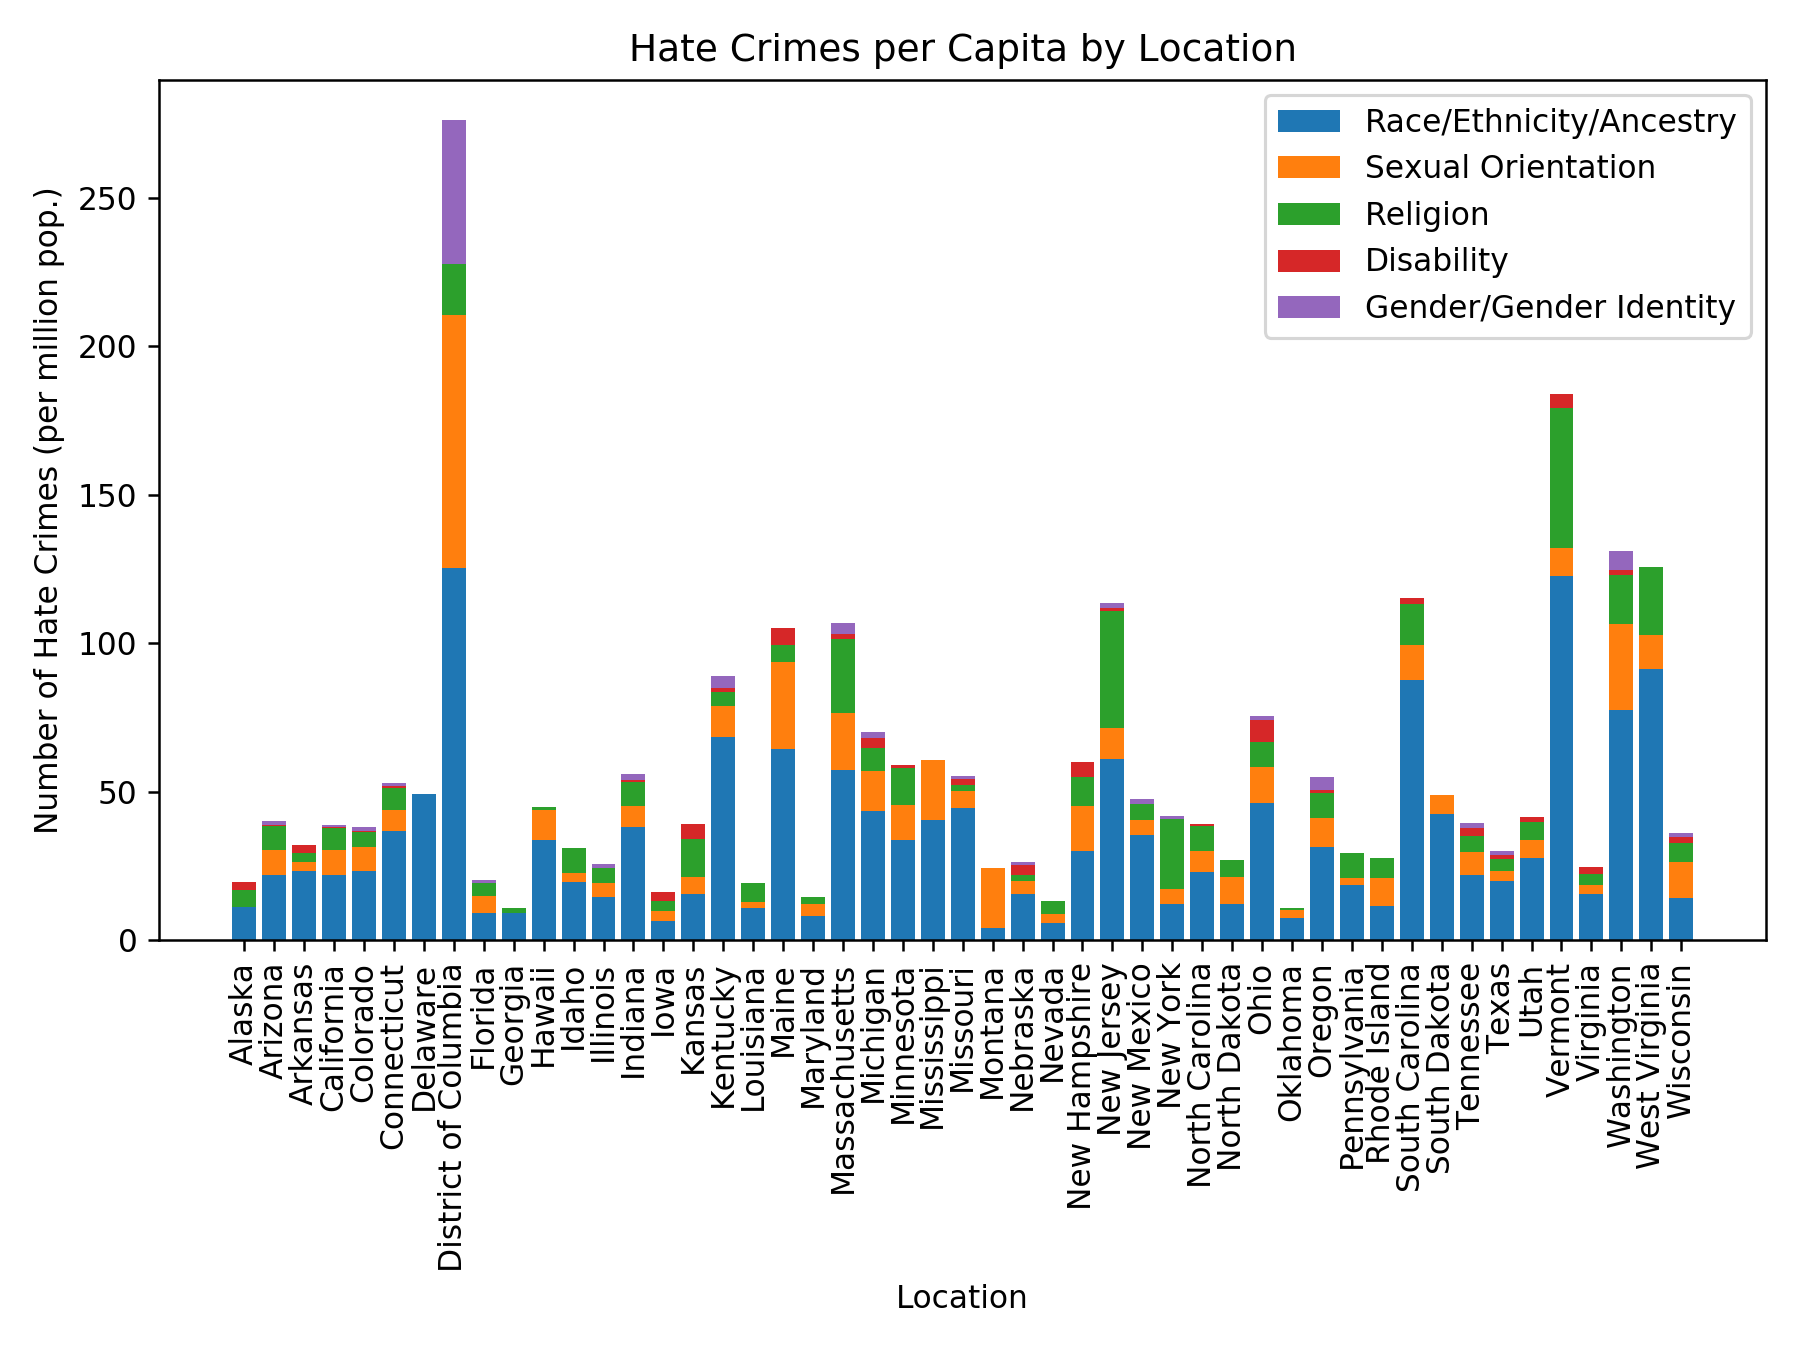

In [9]:
plt.figure(figsize=(8,6))

race = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Sexual Orientation"],bottom=grouped_per_capita["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Religion"], bottom = grouped_per_capita["Race/Ethnicity/Ancestry"]+ grouped_per_capita["Sexual Orientation"])
dis = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Disability"], bottom = grouped_per_capita["Race/Ethnicity/Ancestry"] + grouped_per_capita["Sexual Orientation"]+ grouped_per_capita["Religion"])
gen = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Gender"] + grouped_per_capita["Gender identity"], bottom = grouped_per_capita["Race/Ethnicity/Ancestry"]+ grouped_per_capita["Sexual Orientation"] + grouped_per_capita["Religion"] + grouped_per_capita["Disability"])

ind = list(grouped_df.index)
plt.xticks(range(grouped_df.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crimes per Capita by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Number of Hate Crimes (per million pop.)")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

#plt.savefig("HateCrimesPop.png")

In [10]:
grouped_per_capita["Total"] = grouped_per_capita.sum(axis=1)

for x in grouped_per_capita.columns:
    grouped_per_capita[x] = grouped_per_capita[x]/grouped_per_capita["Total"]

<IPython.core.display.Javascript object>


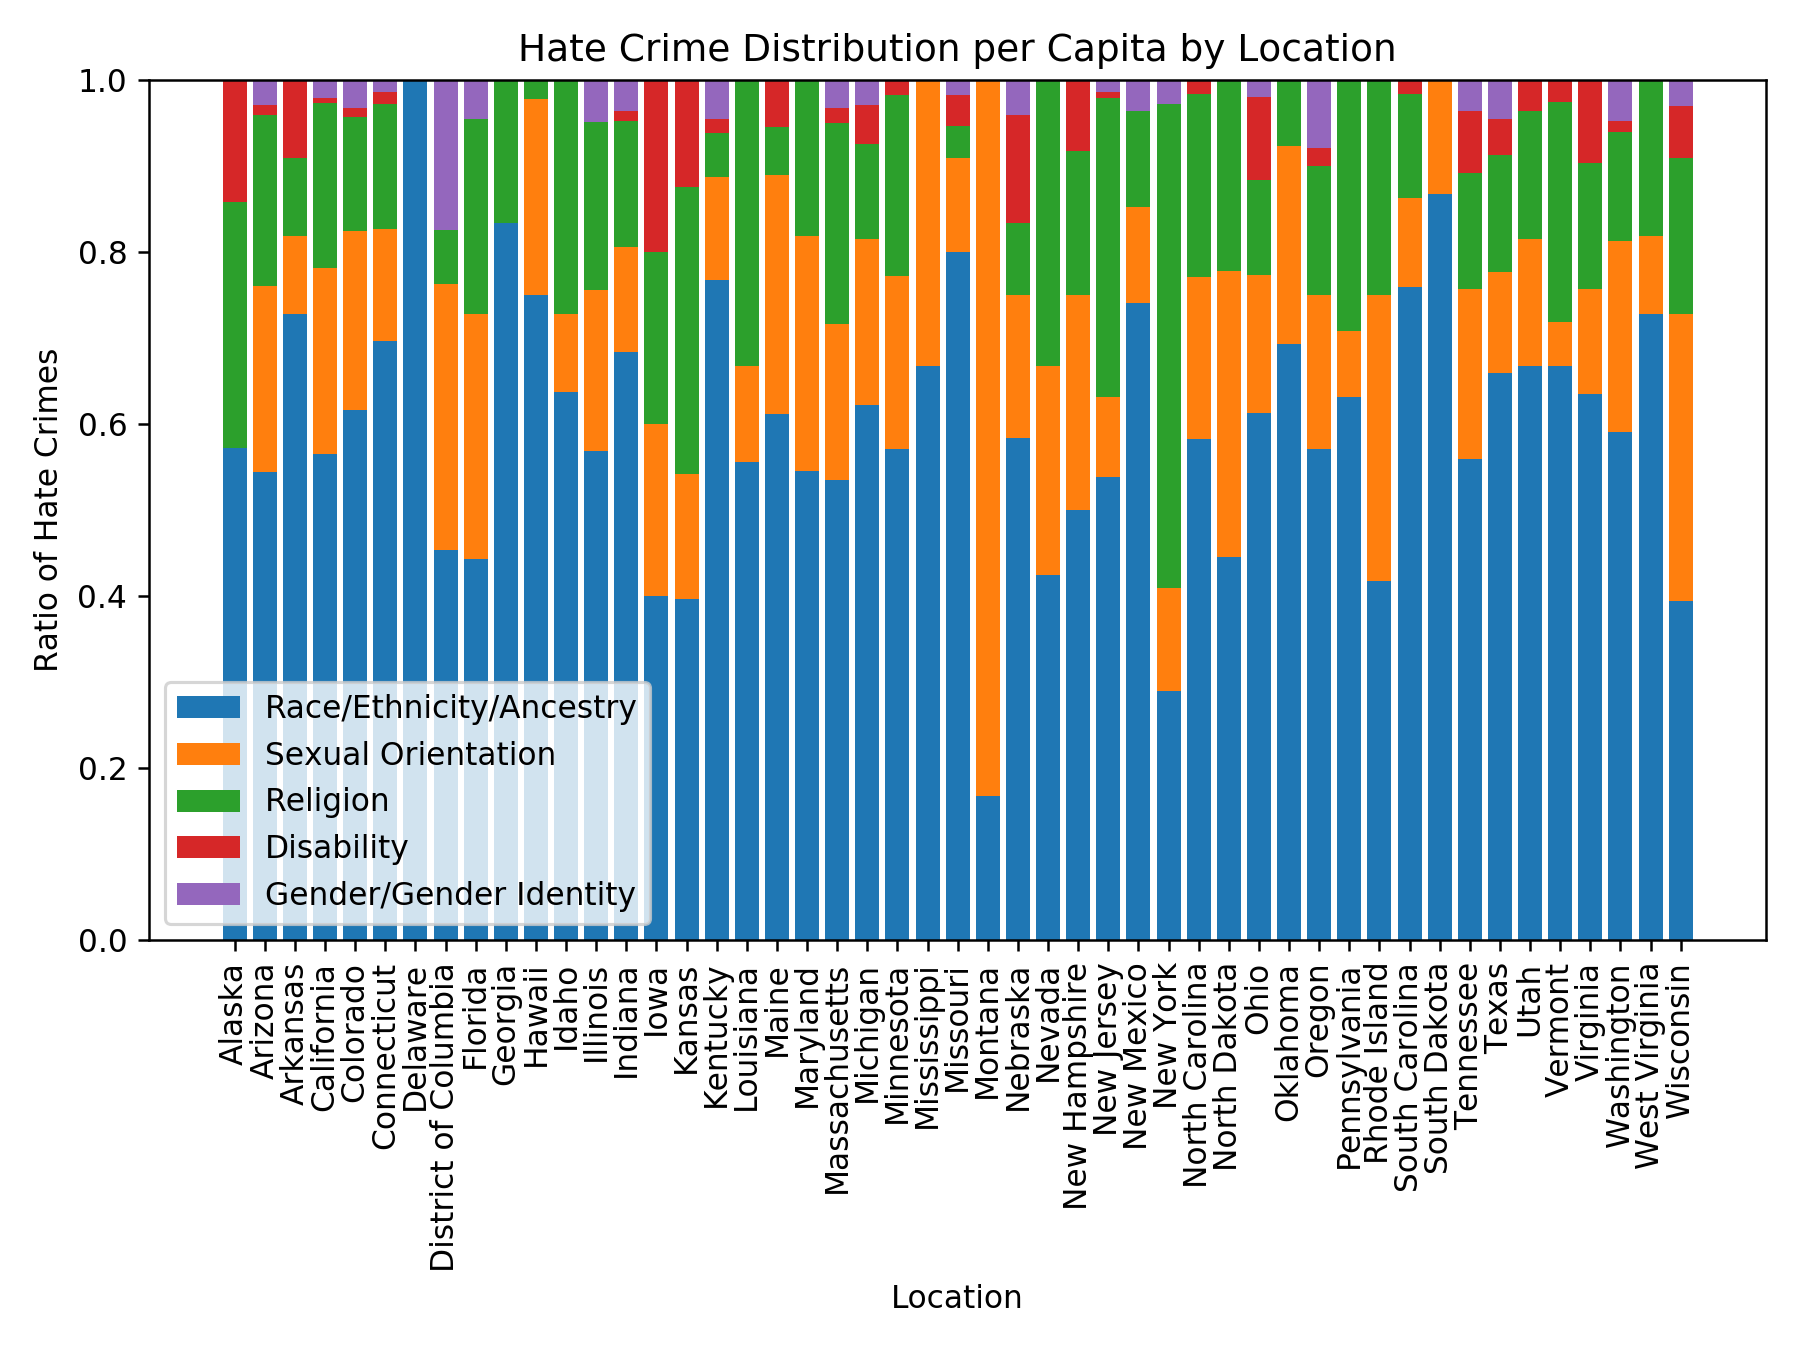

In [11]:
plt.figure(figsize=(8,6))
    
race = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Sexual Orientation"],bottom=grouped_per_capita["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Religion"], bottom = grouped_per_capita["Race/Ethnicity/Ancestry"]+ grouped_per_capita["Sexual Orientation"])
dis = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Disability"], bottom = grouped_per_capita["Race/Ethnicity/Ancestry"] + grouped_per_capita["Sexual Orientation"]+ grouped_per_capita["Religion"])
gen = plt.bar(range(grouped_df.shape[0]),grouped_per_capita["Gender"] + grouped_per_capita["Gender identity"], bottom = grouped_per_capita["Race/Ethnicity/Ancestry"]+ grouped_per_capita["Sexual Orientation"] + grouped_per_capita["Religion"] + grouped_per_capita["Disability"])

ind = list(grouped_df.index)
plt.xticks(range(grouped_df.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crime Distribution per Capita by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Ratio of Hate Crimes")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

#plt.savefig("HateCrimePopRelative.png")

In [12]:
f = gmaps.figure()
l = gmaps.symbol_layer(loc,scale=2)
f.add_layer(l)
f

Figure(layout=FigureLayout(height='420px'))

In [13]:
cd = c.acs.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E", "B23025_005E","B16001_002E"), {'for': 'state:*'})
census_df = pd.DataFrame(cd)
cols = list(census_df.columns)
i = 0
for co in cols:
    if co == "NAME":
        cols[i] = "State"
    if co in censusval:
        cols[i] = censusval[co]
    i = i + 1
census_df.columns = cols
del census_df["state"]
census_df.head()

,State,income,population,age,income_per_capita,poverty,employment_unemployed,language_speak_only_english
0,Minnesota,68411.0,5527358.0,37.9,36245.0,547442.0,119218.0,4571735.0
1,Mississippi,43567.0,2988762.0,37.2,23434.0,599795.0,110036.0,2691455.0
2,Missouri,53560.0,6090062.0,38.5,29537.0,837930.0,155958.0,5367705.0
3,Montana,52559.0,1041732.0,39.8,29765.0,139063.0,22433.0,939716.0
4,Nebraska,59116.0,1904760.0,36.4,31101.0,213790.0,36545.0,1574067.0


In [15]:
grouped_census_df = pd.merge(grouped_df,census_df, how="left",on=["State","State"])
grouped_census_df["PercentEnglish"] = grouped_census_df.language_speak_only_english / grouped_census_df.population
grouped_census_df.head()

,State,Race/Ethnicity/Ancestry,Religion,Sexual Orientation,Disability,Gender,Gender identity,1st quarter,3rd quarter,4th quarter,Population,Total,income,population,age,income_per_capita,poverty,employment_unemployed,language_speak_only_english,PercentEnglish
0,Alaska,4,2,0,1,0,0,1.0,4.0,0.0,358822.0,7,76715.0,738516.0,34.0,35874.0,77865.0,28067.0,573373.0,0.776385
1,Arizona,93,34,37,2,2,3,51.0,35.0,36.0,4275253.0,171,56213.0,6946685.0,37.4,29265.0,1092192.0,210214.0,4740041.0,0.682346
2,Arkansas,8,1,1,1,0,0,4.0,1.0,2.0,342312.0,11,45726.0,2990671.0,37.9,25635.0,510337.0,75774.0,2593351.0,0.867147
3,California,544,185,208,5,4,17,212.0,265.0,228.0,24792513.0,963,71228.0,39148760.0,36.3,35021.0,5487141.0,1321502.0,20487071.0,0.523313
4,Colorado,56,12,19,1,0,3,15.0,21.0,19.0,2398112.0,91,68811.0,5531141.0,36.6,36415.0,590504.0,139326.0,4314327.0,0.780007


In [16]:
#taken from https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    #ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.025
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    #ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

<IPython.core.display.Javascript object>


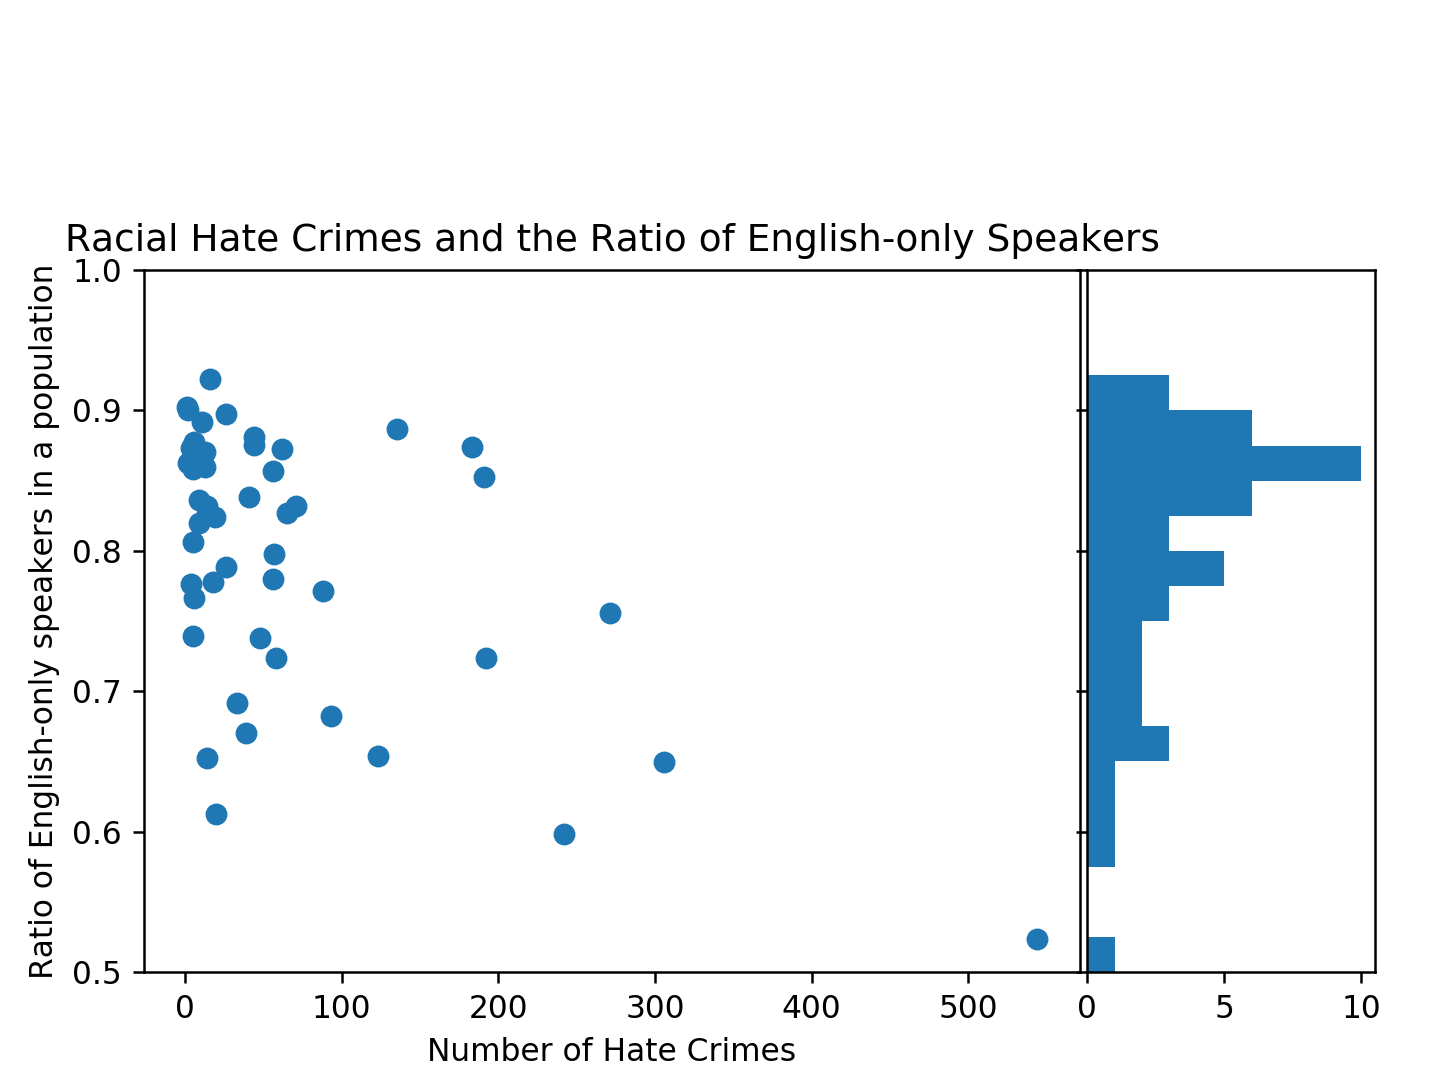

In [18]:
x = grouped_census_df["Race/Ethnicity/Ancestry"]
y = grouped_census_df["PercentEnglish"]

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure()

ax = fig.add_axes(rect_scatter)

plt.title("Racial Hate Crimes and the Ratio of English-only Speakers")
plt.xlabel("Number of Hate Crimes")
plt.ylabel("Ratio of English-only speakers in a population")

ax_histx = ""#fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)
plt.ylim(0.5,1)

plt.show()

#plt.savefig("SHRace.png")

In [18]:
sci.pearsonr(grouped_census_df["Race/Ethnicity/Ancestry"],grouped_census_df["PercentEnglish"])

(-0.5474155325921943, 4.6904447245066614e-05)

<IPython.core.display.Javascript object>


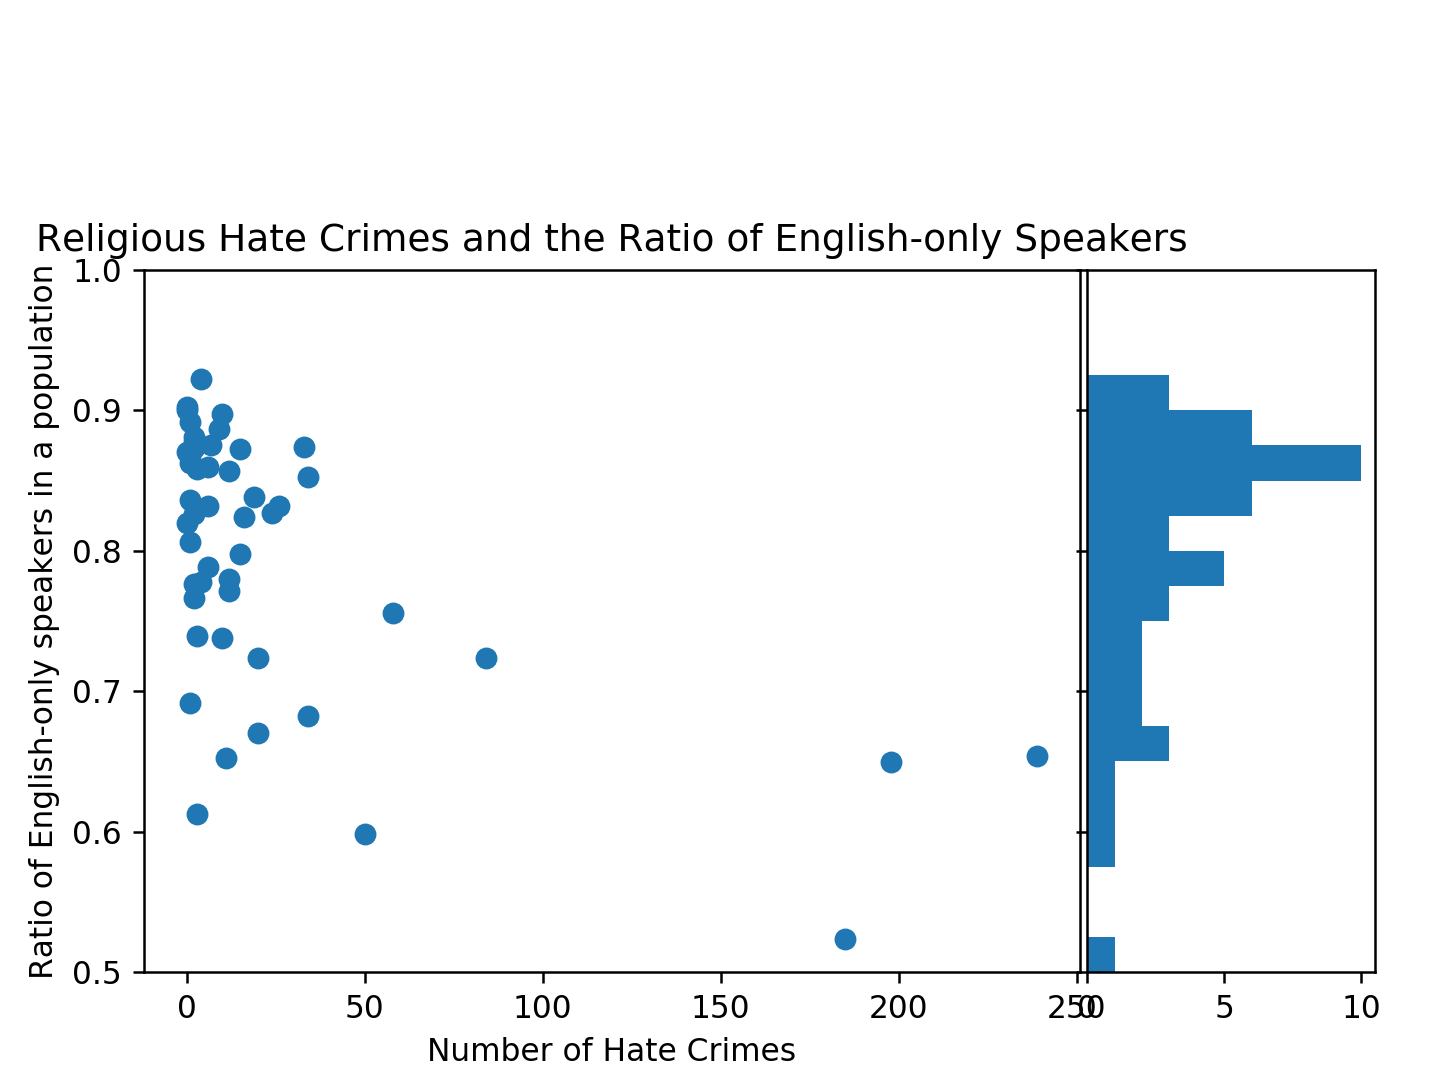

In [19]:
grouped_census_df = pd.merge(grouped_df,census_df, how="left",on=["State","State"])

grouped_census_df["PercentEnglish"] = grouped_census_df.language_speak_only_english / grouped_census_df.population

#plt.scatter(grouped_census_df["Religion"],grouped_census_df["PercentEnglish"])
x = grouped_census_df["Religion"]
y = grouped_census_df["PercentEnglish"]

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure()

ax = fig.add_axes(rect_scatter)

plt.title("Religious Hate Crimes and the Ratio of English-only Speakers")
plt.xlabel("Number of Hate Crimes")
plt.ylabel("Ratio of English-only speakers in a population")

ax_histx = ""#fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)


# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)
plt.ylim(0.5,1)

plt.show()

#plt.savefig("SHRel.png")

In [20]:
sci.pearsonr(grouped_census_df["Religion"],grouped_census_df["PercentEnglish"])

(-0.5766945328172296, 1.4446413510251614e-05)

<IPython.core.display.Javascript object>


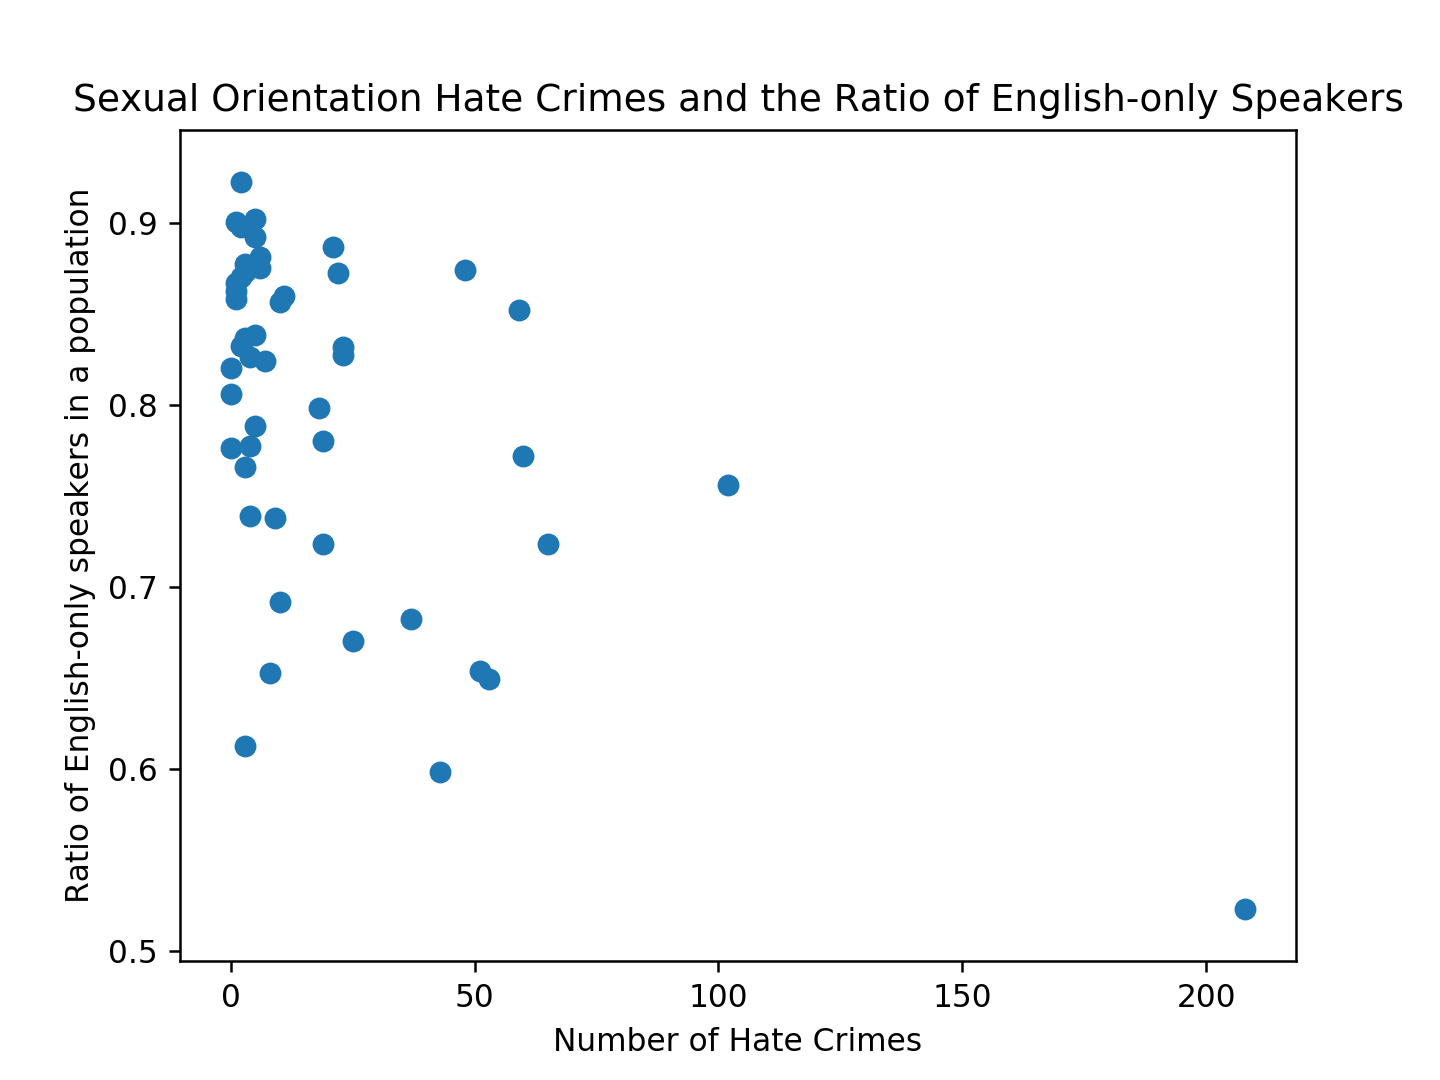

In [20]:
plt.scatter(grouped_census_df["Sexual Orientation"],grouped_census_df["PercentEnglish"])
plt.title("Sexual Orientation Hate Crimes and the Ratio of English-only Speakers")
plt.xlabel("Number of Hate Crimes")
plt.ylabel("Ratio of English-only speakers in a population")
plt.show()
#plt.savefig("SSex.png")

In [22]:
sci.pearsonr(grouped_census_df["Sexual Orientation"],grouped_census_df["PercentEnglish"])

(-0.5466954394263093, 4.821656664722198e-05)

<IPython.core.display.Javascript object>


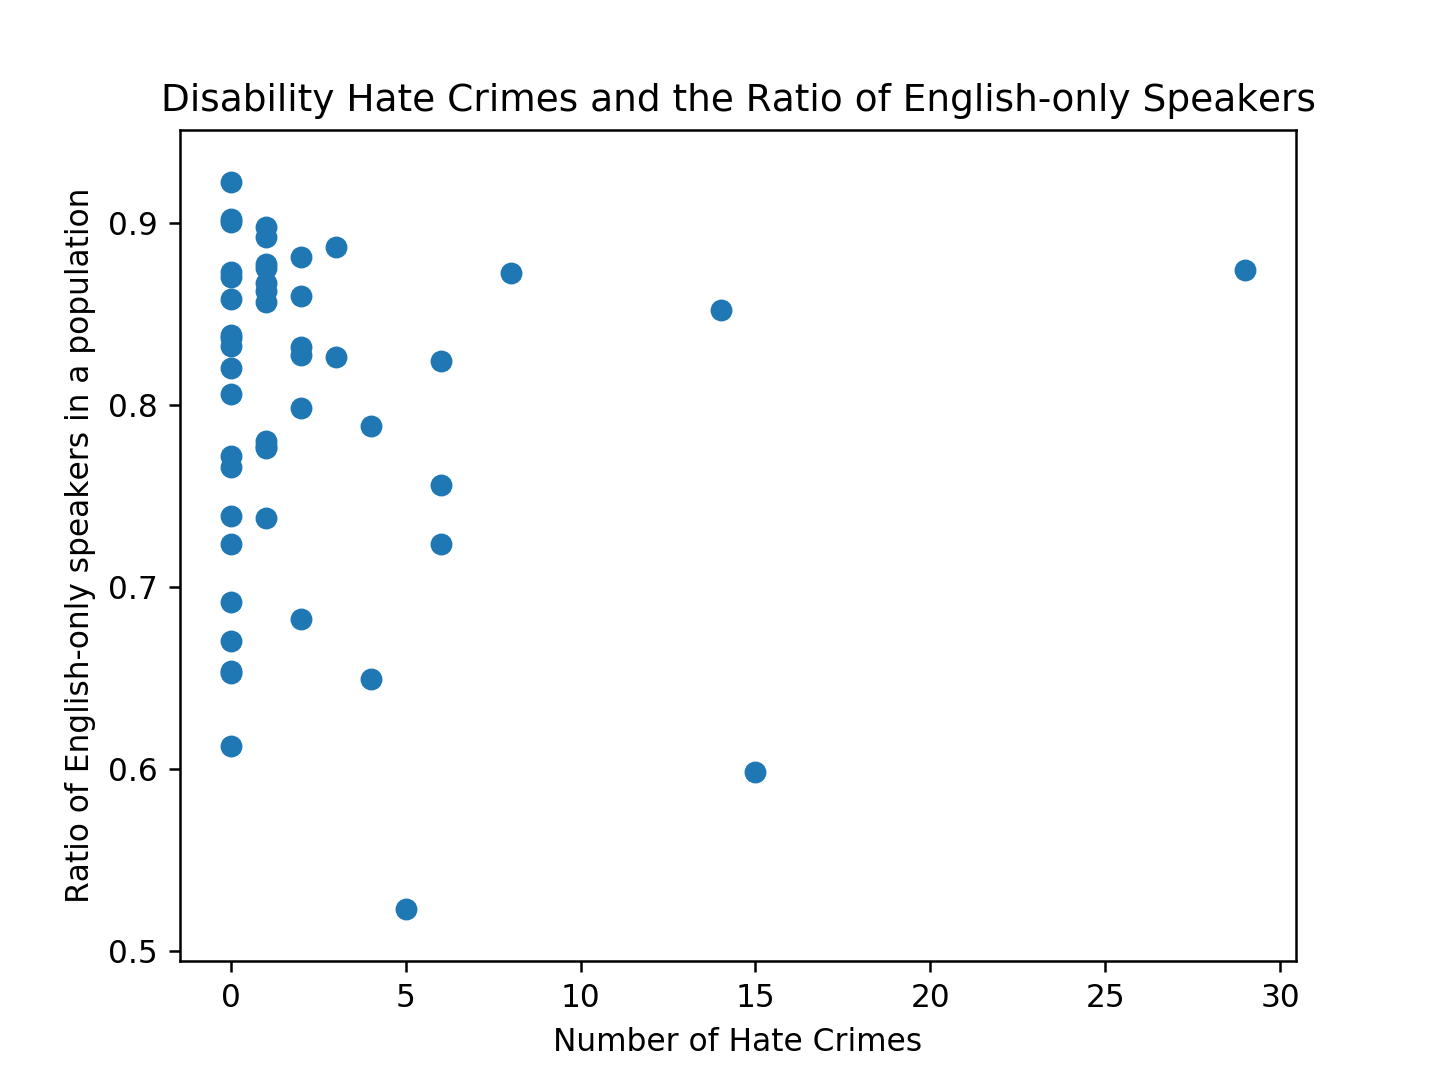

In [21]:
plt.scatter(grouped_census_df["Disability"],grouped_census_df["PercentEnglish"])
plt.title("Disability Hate Crimes and the Ratio of English-only Speakers")
plt.xlabel("Number of Hate Crimes")
plt.ylabel("Ratio of English-only speakers in a population")
plt.show()
#plt.savefig("SDisability.png")

In [34]:
sci.pearsonr(grouped_census_df["Disability"],grouped_census_df["PercentEnglish"])

(-0.03339095883123549, 0.8198280175299527)

<IPython.core.display.Javascript object>


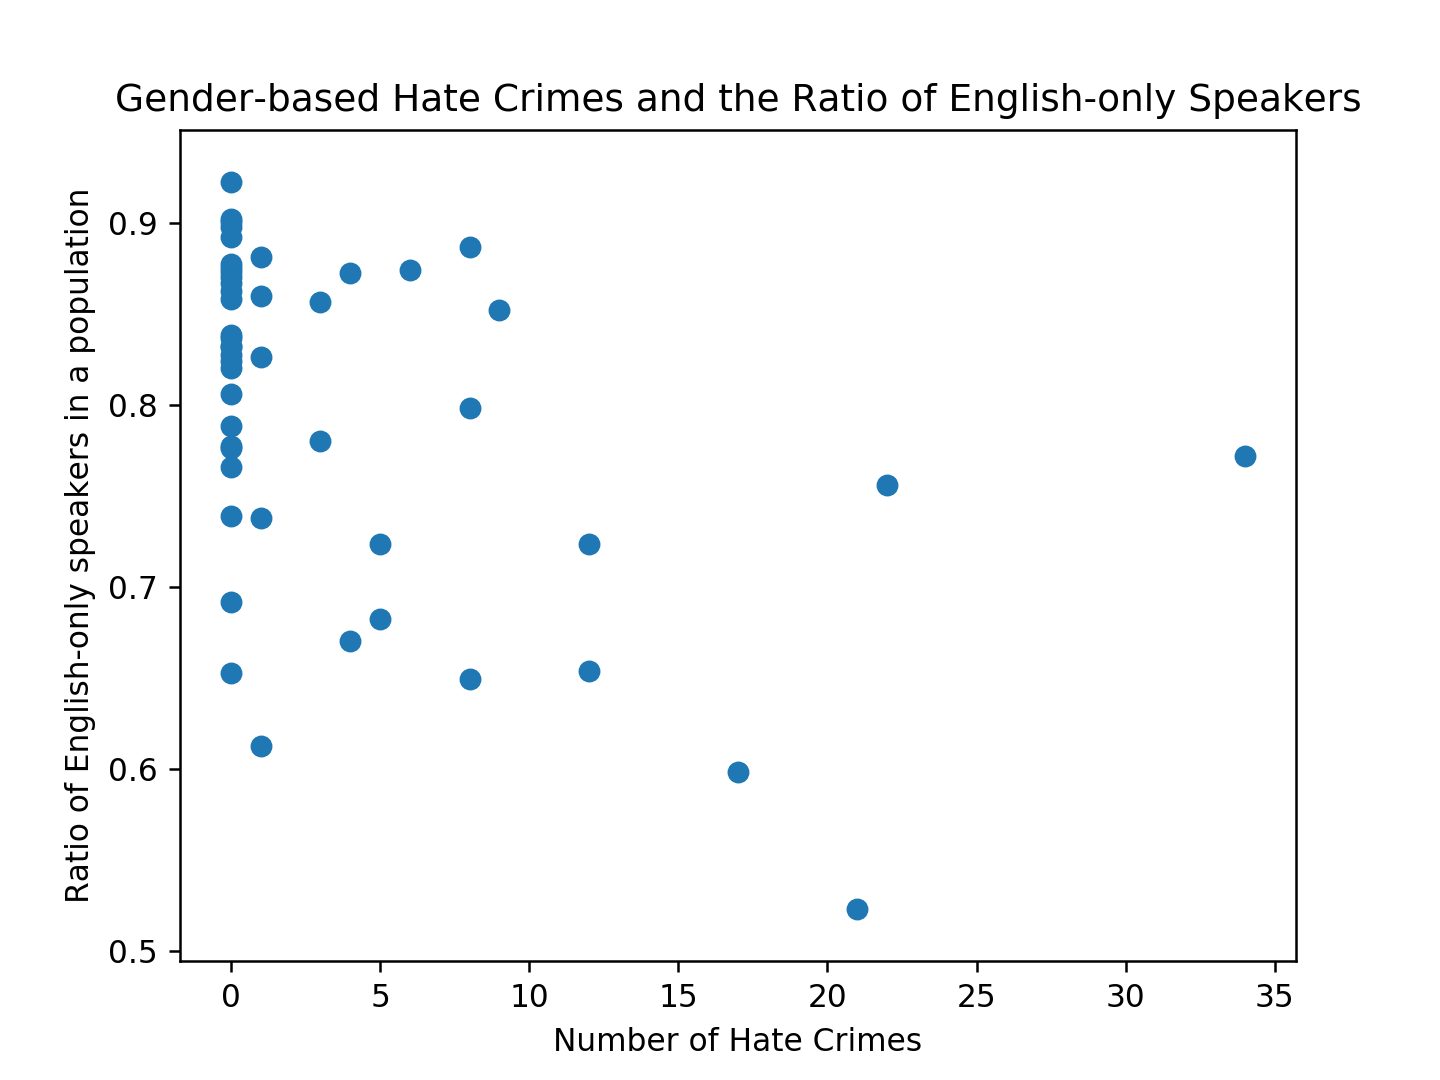

In [22]:
plt.scatter(grouped_census_df["Gender"]+grouped_census_df["Gender identity"],grouped_census_df["PercentEnglish"])
plt.title("Gender-based Hate Crimes and the Ratio of English-only Speakers")
plt.xlabel("Number of Hate Crimes")
plt.ylabel("Ratio of English-only speakers in a population")
plt.show()
#plt.savefig("SGender.png")

In [31]:
sci.pearsonr(grouped_census_df["Gender"]+grouped_census_df["Gender identity"],grouped_census_df["PercentEnglish"])

(-0.44290016236111207, 0.0014382354940464539)

<IPython.core.display.Javascript object>


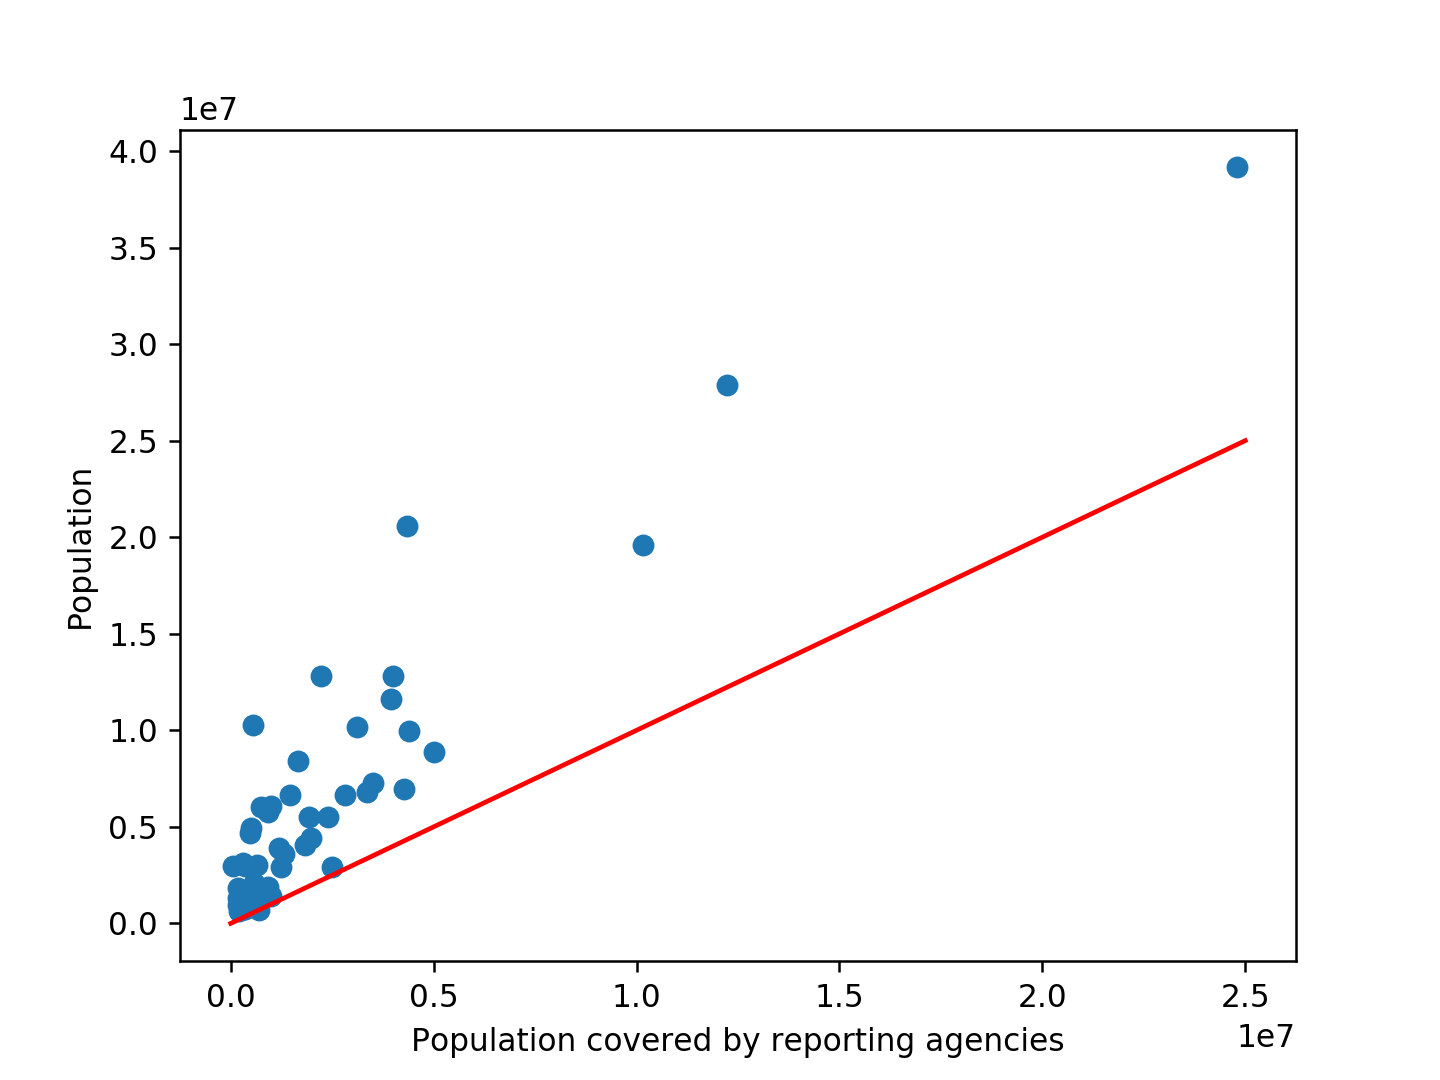

Text(0, 0.5, 'Population')

In [23]:
plt.scatter(grouped_census_df["Population"],grouped_census_df["population"])
plt.plot([0,25000000],[0,25000000],c='r')

plt.xlabel("Population covered by reporting agencies")
plt.ylabel("Population")

<IPython.core.display.Javascript object>


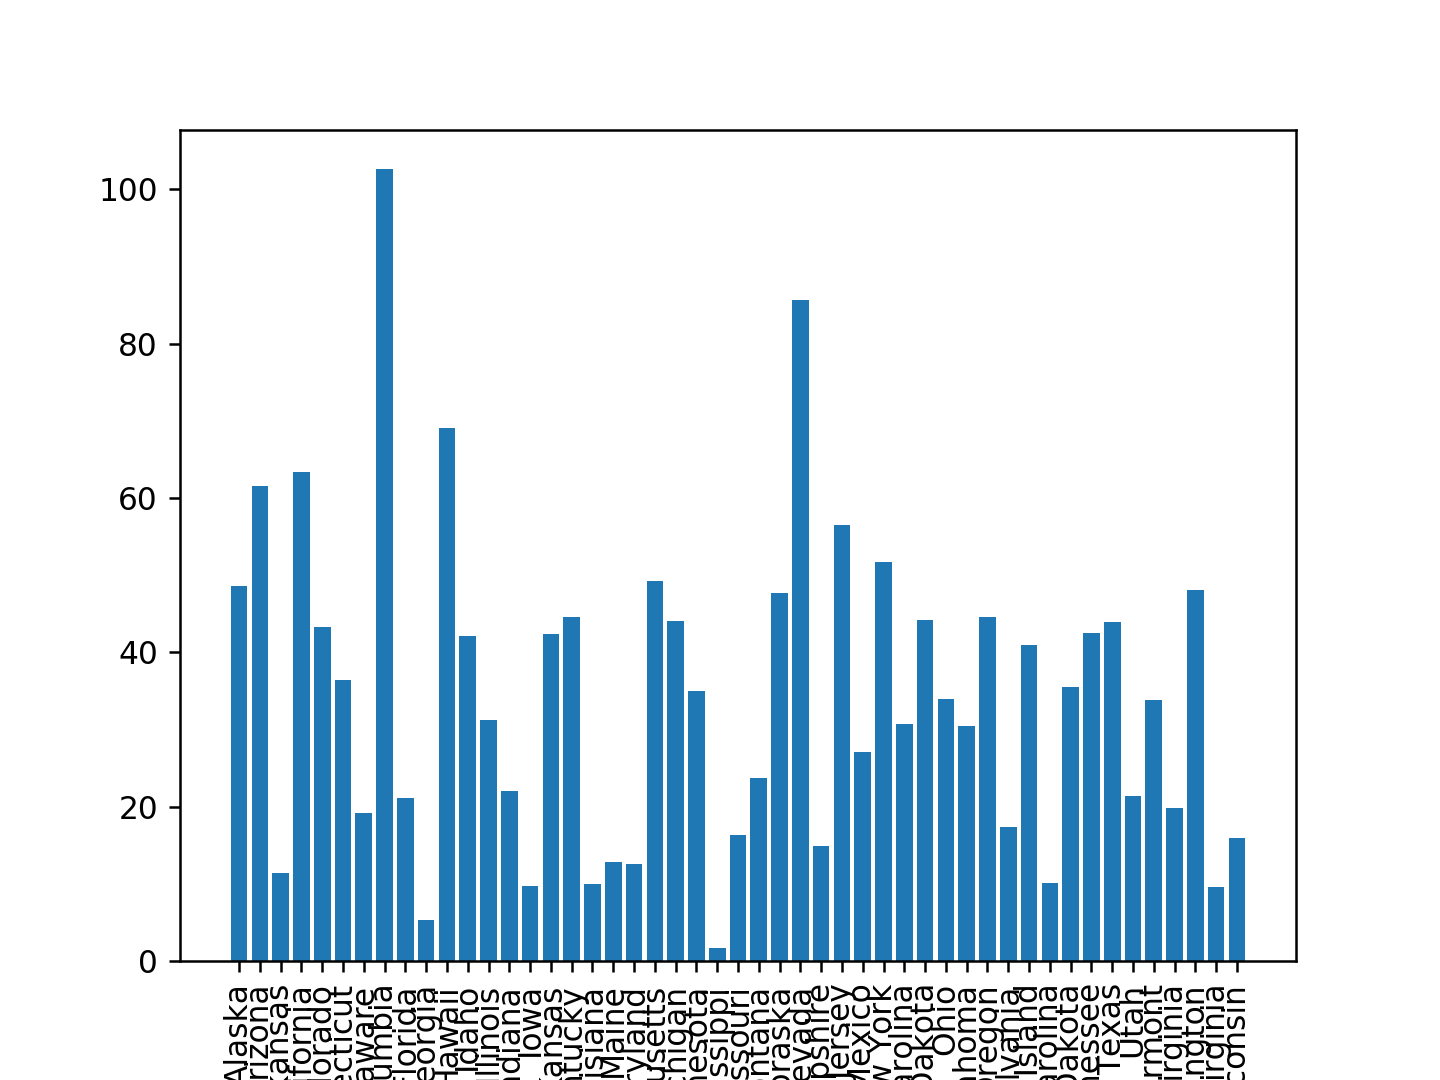

In [24]:
grouped_census_df["PerPop"] = grouped_census_df["Population"]/grouped_census_df["population"]*100

plt.bar(range(grouped_census_df.shape[0]),grouped_census_df["PerPop"])

ind = list(grouped_df.index)
plt.xticks(range(grouped_df.shape[0]),labels=ind, rotation = 90)
plt.show()

In [26]:
#grouped_census_df[["State","PerPop"]].sort_values("PerPop").to_csv("PercentPopulation.csv")